# Import Packages

In [1]:
#Import packages
import numpy as np
import torch
# import scipy.interpolate
import math
# from scipy.integrate import quad
from tqdm import trange
import Krylov
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap

# Functions for generating: the graph, initial vector, time dependent pulse etc.

In [2]:
#Functions which generate graphs and initial condition
def randblock(N):
    H = torch.zeros((N,N),dtype = torch.complex128)
    H1 = torch.rand((N-1,N-1),dtype = torch.float64)*10-5
    T = H1 - torch.transpose(H1,0,1)
    H[0:N-1,0:N-1] = T
    for i in range (N-1):
        H[i,-1] += -torch.sum(T[i,:])
        H[-1,i] += -torch.sum(T[:,i])
    return H

def D1(N):
    wraps = torch.zeros((N,N))
    wraps[0,-1] = -1
    wraps[-1,0] = 1
    return (wraps + torch.diag(-torch.ones((N-1,)),-1) + torch.diag(torch.ones((N-1,)),1))/(2*dx)

def D3(N):
    wraps = torch.zeros((N,N))
    wraps[0,-1] = 2
    wraps[0,-2] = -1
    wraps[-1,0] = -2
    wraps[-2,0] = 1
    wraps[1,-1] = -1
    wraps[-1,1] = 1
    return (wraps + torch.diag(-torch.ones((N-2,)),-2) + torch.diag(2*torch.ones((N-1,)),-1) - torch.diag(2*torch.ones((N-1,)),1) + torch.diag(torch.ones((N-2,)),2))/(2*dx**3)

def loop(N):
    conn = torch.rand((N-1,))
    wraps = torch.zeros((N,N))
    wraps[-1,0] = torch.sum(conn)
    wraps[0,-1] = -torch.sum(conn)
    return torch.diag(conn,1) - torch.diag(conn,-1) + wraps

def block(N):
    return D1(N) + 1e-1*D3(N) + 1e-1*randblock(N)#loop(N)

def Ham(N,NBlock = 100):
    H = torch.zeros((N,N),dtype = torch.complex128)
    BD = torch.zeros((N,N),dtype = torch.complex128)
    B = torch.zeros((N,NBlock),dtype = torch.complex128)
    for i in range (int(N/NBlock)):
        blk = randblock(NBlock)
        B[i*NBlock:(i+1)*NBlock,:] = blk
        BD[i*NBlock:(i+1)*NBlock,i*NBlock:(i+1)*NBlock] = blk
    S = sparse(N)
    H = S + BD
    return H,BD,B


def sparse(N,sparsity = 0.9999):
    S = torch.zeros((N,N),dtype = torch.float64)
    randvals = torch.rand(math.floor((1-sparsity)*(N**2)),dtype = torch.float64)#*10-2
    indx = torch.randperm(N**2)
    for i in range (len(randvals)):
        S[int(torch.floor(indx[i]/N)),int(indx[i]%N)] = randvals[i]
    S = S - torch.transpose(S,0,1)
    return S


def c(i):
    sigma1 = 20
    sigma2 = 1
    i0 = 25
    # wide = math.exp((-1*(i-i0)**2)/(2*sigma1**2))
    dist = torch.distributions.uniform.Uniform(0,1e-4)
    wide = dist.sample()
    narrow = math.exp((-1*(i-i0)**2)/(2*sigma2**2))
    return narrow + wide

def init(A0,Ae):
    N = len(A0)
    L,V = torch.linalg.eig(A0)
    sort, index = torch.sort(L.imag)
    L = L[index]
    V = V[:,index]
    v = torch.zeros((N,),dtype = torch.complex128)
    for i in range (N):
        v += c(i)*V[:,i]
    # v = V[:,5]
    # dist = torch.distributions.uniform.Uniform(0,1e-4)
    # for i in range (len(L)):
    #     v += dist.sample()*V[:,i]
    # v = torch.matrix_exp(200*Ae) @ v
    return torch.tensor((v.real/Krylov.L2.Norm(v.real,dx)),dtype = torch.complex128)

In [3]:
#time-dependent pulse
import bisect

# def e(tau):
#     a = 1
#     sigma = t[-1]/5
#     alpha = t[-1]/2
#     omega = 5e-2*(1000/t[-1])
#     return a*np.exp(-((tau-alpha)**4)/(2*sigma**4))*np.sin(omega*tau)

def e(tau):
    a = np.array([0,0,1,2,1,0,-1,-2,-1,0])/2
    # stepst = torch.tensor((torch.arange(1,11)*n/10),dtype = torch.int)*dt
    stepst = np.array(np.arange(1,10)*n/10,dtype=np.int8)*dt
    i = bisect.bisect_right(stepst,tau) 
    return a[i]

    

In [4]:
#magnus expansion
# def magnus(A0,A1,t,dt):
#     roots = torch.tensor([-0.77459667,  0.        ,  0.77459667])
#     weights = torch.tensor([0.55555556, 0.88888889, 0.55555556])
#     # roots,weights = scipy.special.roots_legendre(101)
#     # roots  = torch.tensor(roots)
#     # weights = torch.tensor(weights)
#     Comm = torch.matmul(A1,A0) - torch.matmul(A0,A1)
#     def r(t,dt):
#         return torch.tensor(dt* e(dt/2 * roots + t+dt/2).dot(weights)/(2*dt))

#     def sfunc(zeta):
#         return (zeta-dt/2)*e(t+zeta)

#     def s(t,dt):
#         return torch.tensor(dt*sfunc(dt/2 * roots + dt/2).dot(weights))
#     return dt*A0 + dt*A1*r(t,dt) - Comm*s(t,dt)/2

def magnus(A0,A1,t,dt):
    return dt*(A0 + e(t)*A1)

# Generate graph and block-diagonal matrices, initial vector, as well as variables for time step, grid size, Krylov dimension etc.

In [5]:
#Initialise variables.
# dt = 1e-7# time step
dt = 8e-2
N = 1000 # spatial dimension size
dx = 1/N
n = 100 # number of time steps
t = torch.linspace(0,n*dt,n+1) # time vector
m = 20 # Krylov subspace dimension
A1,BD1,B1 = Ham(N,int(N/10)) # Generate random graph and block diagonal
# rand = torch.rand((N,N),dtype = torch.float64) - 1/2 # Generate matrix with random elements in U(-1/2,1/2)
# rand = rand + rand.T
# A2 = A1 * rand # Generate random graph as random change in elements of A1
A2,BD2,B2 = Ham(N,int(N/10))
# BD2 = BD1 * rand # Generate Block-diagonal of A2
M0 = magnus(A1,A2,t[0],dt)
Me = magnus(A1,A2,t[40],dt)
v = init(M0,Me) # Generate initial condition


C:\Users\mt767\AppData\Local\Temp\ipykernel_22164\1830453005.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((v.real/Krylov.L2.Norm(v.real,dx)),dtype = torch.complex128)


In [15]:
#Save variables
torch.save(A1,"graph_data/A1.pt")
torch.save(A2,"graph_data/A2.pt")
torch.save(BD1,"graph_data/BD1.pt")
torch.save(BD2,"graph_data/BD2.pt")
torch.save(v,"graph_data/v.pt")
torch.save(dt,"graph_data/dt.pt")
torch.save(n,"graph_data/timestep_no.pt")
torch.save(N,"graph_data/N.pt")
torch.save(t,"graph_data/t.pt")
torch.save(m,"graph_data/m.pt")

In [16]:
#Load variables
A1=torch.load("graph_data/A1.pt")
A2=torch.load("graph_data/A2.pt")
BD1=torch.load("graph_data/BD1.pt")
BD2=torch.load("graph_data/BD2.pt")
v=torch.load("graph_data/v.pt")
dt=torch.load("graph_data/dt.pt")
n=torch.load("graph_data/timestep_no.pt")
N=torch.load("graph_data/N.pt")
t=torch.load("graph_data/t.pt")
m=torch.load("graph_data/m.pt")

# Compute reference solution by brute force


In [7]:
#Compute reference solution by brute force
def Reference(A1,A2,t,v):
    time = torch.linspace(t[0],t[-1],1*(len(t)-1)+1)
    dtime = time[1] - time[0]
    out = torch.zeros((len(v),len(time)),dtype = torch.complex128)
    out[:,0] = v
    for i in trange (len(time)-1):
        M = magnus(A1,A2,time[i],dtime)
        out[:,i+1] = torch.matrix_exp(M) @ out[:,i]
        # print('t = {0:^4.3f}'.format(time[i+1]),end='\r')
    return out
glo_ref = Reference(A1,A2,t,v)
torch.save(glo_ref,"graph_data/Ref_Sol.pt")

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


In [8]:
#Load reference solution
glo_ref = torch.load("graph_data/Ref_Sol.pt")

# Generate contour plot of the true loss or defect plotted against the shift

In [17]:
#Parameter sweep over a given range
def Sweep(gammaR,gammaI,H,v,dt,dx,m,loss_fn):
    loss = torch.zeros((len(gammaI),len(gammaR)))
    Ref = Krylov.Solution.Exact(H,v,dt,torch.matrix_exp)
    for i in range (len(gammaI)):
        for j in range (len(gammaR)):
            print('[{0:^3d},{1:^3d}]'.format(i,j),end='\r')
            # gamma = gammaR[j] + 1j*gammaI[i]
            # Vm,Hm,beta = Krylov.Arnoldi.Polynomial(H,v,m,gamma,dx,"Shift Invert")
            loss[i,j] = Krylov.Optimise.loss(H,v,dt,dx,m,[gammaR[j],gammaI[i]],loss_fn)
            # if loss_fn == "defect":
            #     loss[i,j] = Krylov.Optimise.loss(H,v,dt,dx,m,[gammaR[j],gammaI[i]],"defect")
            #     # Vm,Hm,beta = Krylov.Arnoldi.Polynomial(H,v,m,gamma,dx,"Shift Invert")
            #     # Vm = Vm[:,0:-1]
            #     # Hm = Hm[0:-1,0:-1]
            #     # Am = gamma*torch.eye(len(Hm)) - torch.linalg.inv(Hm)
            #     # loss[i,j] = Krylov.Solution.defect(H,Vm,Am,beta,dt,dx,m)
            # elif loss_fn == "l2":
            #     # gamma = gammaR[j] + 1j*gammaI[i]
            #     # X = torch.linalg.inv(H - gamma*torch.eye(len(v)))
            #     # Vm,Hm,beta = Krylov.Arnoldi.Polynomial(X,v,m,gamma,dx,"Polynomial")
            #     # Am = Krylov.Solution.Rayleigh_Quotient(H,Vm,Hm,gamma,dx)
            #     # REst = Krylov.Solution.Polynomial(Vm[:,0:-1],Am,dt,beta,torch.matrix_exp)
            #     # loss[i,j] = Krylov.L2.Error(REst,Ref,dx)
            #     loss[i,j] = Krylov.Optimise.loss(H,v,dt,dx,m,[gammaR[j],gammaI[i]],"l2")
    return loss



In [18]:
#Contour plot
def Contour(gammaR,gammaI,loss,shifts = [0],randshifts = [0],optshift = [0]):
    hold = torch.nan_to_num(loss,nan=1e0)
    # if torch.log10(torch.max(hold)) < -2:
    levels = torch.logspace(torch.log10(torch.min(hold)),min(-2,torch.log10(torch.max(hold))),11)
    # else:
    #     levels = torch.logspace(torch.floor(torch.log10(torch.min(hold))),torch.ceil(torch.log10(torch.max(hold))),int(1+torch.ceil(torch.log10(torch.max(hold)))-torch.floor(torch.log10(torch.min(hold)))))
    cont = plt.contour(gammaR,gammaI,loss,levels,norm=LogNorm())
    fmt = '%1.1e'  # Exponential format
    plt.clabel(cont, inline=True, fontsize=8, fmt=fmt, colors='black', manual=False, inline_spacing=3)
    # plt.title("Rayleigh")
    if optshift != [0]:
        marker = ['o','s']
        for i in range(len(optshift)):
            plt.plot(optshift[i].real,optshift[i].imag,marker = marker[i],color = 'k')
    if randshifts != [0]:
        plt.plot(randshifts.real,randshifts.imag,'^',color = [0,0.2,0.8])
    if shifts != [0]:
        col = [1,0.1,0.2]#],[0,0.6,0.1]
        for i in range(len(shifts)):
            plt.plot(shifts[i].real,shifts[i].imag,'x',color = 'r')
            # for j in range (len(shifts[i])+1):
        for i in range(len(shifts)-1):
            plt.arrow(shifts[i].real,shifts[i].imag,shifts[i+1].real - shifts[i].real,shifts[i+1].imag - shifts[i].imag,linestyle = (3,(3,6)),color = 'k',head_length = 0)


tensor(1.3296e-06)


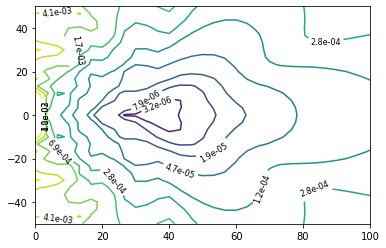

In [21]:
gammaR = torch.linspace(0,100,31)
gammaI = torch.linspace(-50,50,31)
M = magnus(A1,A2,t[0],dt)
loss_fn = "defect"
# loss_fn = "l2"
loss = Sweep(gammaR,gammaI,M,v,1,dx,m,loss_fn)
torch.save(loss,"graph_data/"+loss_fn+"_sweep.pt")
print(torch.min(loss))
Contour(gammaR,gammaI,loss)

# Run shift-and-invert Krylov time integration

In [9]:
#Fine Grid Optimisation
def Time_Int(A1,A2,BD1,BD2,v,m,dt,dx,t,ftol,glo_ref,surrogate = False):
    # true_shifts = torch.load("Figures/Shift_Optimiser_Plots/Schrodinger/Time_Independent_Hamiltonian/Coarse_Grid/Optimiser/Coarse_Coulomb_OptPath.pt")
    print('t = {0:^4.2f}'.format(t[0]),end='\n')
    # coarse_dx = dx*(len(v)-1)/(coarse_N-1)
    # coarse_Magnus = magnus(t,coarse_N,dt,coarse_dx)
    # coarse_v = Krylov.Optimise.interpv(v,coarse_N,[-240,240])
    M = magnus(A1,A2,t[0],dt)
    if surrogate == True:
        BDM = magnus(BD1,BD2,t[0],dt)
    else: 
        BDM = M
    options = {'iprint':0,
           'maxiter':100,
           'disp': True,
           'gtol':1e-15,
           'ftol':1e-30}
    
    Num_sols = torch.reshape(v,[len(v),1])
    
    energy = torch.tensor([Krylov.L2.IP(v,M @ v,dx)**(1/2)])

    true_shifts,true_loss,rawshifts,obj_loss,randgammas = Krylov.Optimise.Optimise(A = BDM,
                                                                    v = v,
                                                                    dx = dx,
                                                                    m = m,
                                                                    true_dt=1,
                                                                    coarse_dt=1,
                                                                    coarse_N=len(v),
                                                                    options=options,
                                                                    tol = ftol,
                                                                    print_output=True,
                                                                    return_loss=True,
                                                                    rand_n=3,
                                                                    # x0 = [15.489261194256,-0.163755180290],
                                                                    rand_bounds=[[0,100],[-50,0]],
                                                                    # bounds = [(0,100),(-100,100)],
                                                                    loss_fn = "defect")
    torch.save(randgammas,"graph_data/randshifts.pt")
    torch.save(true_shifts,"graph_data/optpath.pt")
    torch.save(obj_loss,"graph_data/objloss.pt")
    # for i in range (len(true_shifts)):
    #     true_loss[i] = Krylov.Optimise.loss(magnus,v,1,dx,m,[true_shifts[i].real,true_shifts[i].imag],"l2")
    torch.save(true_loss,"graph_data/trueloss.pt")
    X = torch.linalg.inv(M - true_shifts[-1]*torch.eye(len(v)))
    Vm,Hm,beta = Krylov.Arnoldi.Polynomial(X,v,m,1)
    # Est = Krylov.Solution.Shift_Invert(Vm,Hm,1,beta,true_shifts[-1],torch.matrix_exp)
    # Est = Krylov.Solution.Rayleigh(Vm,A,dt,dx,beta,torch.matrix_exp)
    Am = Krylov.Solution.Rayleigh_Quotient(M,Vm,Hm,true_shifts[-1],1)
    # Am = torch.linalg.inv(Hm[0:-1,0:-1]) + true_shifts[-1]*torch.eye(m)
    Est = Krylov.Solution.Polynomial(Vm[:,0:-1],Am,1,beta,torch.matrix_exp)
    Ref = torch.matrix_exp(M) @ v
    objective = torch.tensor([obj_loss[-1]])
    opt_shifts_t = torch.tensor([true_shifts[-1]])
    N_iter = torch.tensor([len(true_shifts)-1])
    Glo_error = torch.tensor([Krylov.L2.Error(Est,glo_ref[:,1],dx)])
    Loc_error = torch.tensor([Krylov.L2.Error(Est,Ref,dx)])
    Num_sols = torch.cat((Num_sols,torch.reshape(Est,[len(Est),1])),dim=1)
    

    for i in range (1,len(t)-1):
        print('t = {0:^4.10f}'.format(t[i]),end='\n')
        M = magnus(A1,A2,t[i],dt)
        if surrogate == True:
            BDM = magnus(BD1,BD2,t[i],dt)
        else:
            BDM = M
        
        energy = torch.cat((energy,torch.tensor([Krylov.L2.IP(Est,M @ Est,dx)**(1/2)])))
        # coarse_Magnus = magnus(t,coarse_N,dt,coarse_dx)
        # coarse_v = Krylov.Optimise.interpv(Est,coarse_N,[-240,240])
        # true_shifts,true_loss,rawshifts,obj_loss,randgammas = Krylov.Optimise.Optimise(A = BDM,
        #                                                             v = Est,
        #                                                             dx = dx,
        #                                                             m = m,
        #                                                             true_dt=1,
        #                                                             coarse_dt=1,
        #                                                             coarse_N=len(v),
        #                                                             options=options,
        #                                                             tol = ftol,
        #                                                             print_output=True,
        #                                                             return_loss=False,
        #                                                             x0 = [true_shifts[-1].real,true_shifts[-1].imag],
        #                                                             #bounds=[(0,100),(-100,0)],
        #                                                             # bounds = [(0,100),(-100,100)],
        #                                                             loss_fn = "defect")
        
    
        objective = torch.cat((objective,torch.tensor([obj_loss[-1]])))
        opt_shifts_t = torch.cat((opt_shifts_t,torch.tensor([true_shifts[-1]])))
        N_iter = torch.cat((N_iter,torch.tensor([len(true_shifts)-1])))
        Ref = torch.matrix_exp(M) @ Est
        X = torch.linalg.inv(M - true_shifts[-1]*torch.eye(len(v)))
        Vm,Hm,beta = Krylov.Arnoldi.Polynomial(X,Est,m,1)
        Am = Krylov.Solution.Rayleigh_Quotient(M,Vm,Hm,true_shifts[-1],1)
        # Am = torch.linalg.inv(Hm[0:-1,0:-1]) + true_shifts[-1]*torch.eye(m)
        Est = Krylov.Solution.Polynomial(Vm[:,0:-1],Am,1,beta,torch.matrix_exp)
        # Est = Krylov.Solution.Shift_Invert(Vm,Hm,1,beta,true_shifts[-1],torch.matrix_exp)
        # Est = Krylov.Solution.Rayleigh(Vm,A,dt,dx,beta,torch.matrix_exp)
        Num_sols = torch.cat((Num_sols,torch.reshape(Est,[len(Est),1])),dim=1)
        Glo_error = torch.cat((Glo_error,torch.tensor([Krylov.L2.Error(Est,glo_ref[:,1*(i+1)],dx)])))
        Loc_error = torch.cat((Loc_error,torch.tensor([Krylov.L2.Error(Est,Ref,dx)])))
    M = magnus(A1,A2,t[-1],dt)
    energy = torch.cat((energy,torch.tensor([Krylov.L2.IP(Est,M @ Est,dx)**(1/2)])))
    return opt_shifts_t,N_iter,Num_sols,Loc_error,Glo_error,objective,energy
    
# ftol = 1e-6
# Pot_energy,Kin_energy,Tot_energy,opt_shifts_t,N_iter,Num_sols,Loc_error,Glo_error,objective = Time_Int(v,m,dx,dt,t,len(v),ftol,glo_ref)


In [13]:
ftol = 1e-14
opt_shifts_t,N_iter,Num_sols,Loc_error,Glo_error,objective,energy = Time_Int(A1,A2,BD1,BD2,v,m,dt,dx,t,ftol,glo_ref,surrogate=True)


t = 0.00
   0    92.137571-13.445036j    3.62e-04


c:\Users\mt767\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:517: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x0 = np.atleast_1d(np.asarray(x0))
c:\Users\mt767\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:517: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x0 = np.atleast_1d(np.asarray

   1    76.112131+0.126450j    1.83e-04
   2    52.965062+7.977428j    2.77e-05
   3    49.452193+8.756681j    1.62e-05
   4    46.871947+8.365572j    1.20e-05
   5    44.733693+7.573459j    1.02e-05
   6    42.909774+6.632441j    9.31e-06
   7    39.073244+3.444013j    6.70e-06
   8    38.140946+0.550066j    6.57e-06
   9    39.533389+0.266219j    5.08e-06
  10    40.320462-0.421963j    4.84e-06
  11    40.273834+0.022061j    4.82e-06
  12    40.328374+0.170790j    4.80e-06
  13    40.342981+0.160522j    4.80e-06
  14    40.368702+0.095860j    4.78e-06
  15    40.378281+0.053602j    4.78e-06
  16    40.381063+0.022931j    4.77e-06
  17    40.381237+0.004747j    4.77e-06
  18    40.379443-0.015239j    4.77e-06
  19    40.378706-0.001172j    4.77e-06
  20    40.379218+0.001608j    4.77e-06
  21    40.379518+0.001712j    4.77e-06
  22    40.379775+0.001378j    4.77e-06
  23    40.380035+0.000751j    4.77e-06
  24    40.380104+0.000421j    4.77e-06
  25    40.380129+0.000106j    4.77e-06


In [28]:
#Save optimiser outputs
torch.save(opt_shifts_t,"graph_data/Optimiser_Shifts.pt")
torch.save(N_iter,"graph_data/No_Iterations.pt")
torch.save(Num_sols,"graph_data/Numerical_Solution.pt")
torch.save(Loc_error,"graph_data/Local_Error.pt")
torch.save(Glo_error,"graph_data/Global_Error.pt")
torch.save(objective,"graph_data/Defect_Error.pt")
torch.save(energy,"graph_data/energy.pt")
torch.save(ftol,"graph_data/ftol.pt")


In [29]:
#Load optimiser outputs
energy = torch.load("graph_data/energy.pt")
opt_shifts_t = torch.load("graph_data/Optimiser_Shifts.pt")
N_iter = torch.load("graph_data/No_Iterations.pt")
Num_sols = torch.load("graph_data/Numerical_Solution.pt")
Loc_error = torch.load("graph_data/Local_Error.pt")
Glo_error = torch.load("graph_data/Global_Error.pt")
objective = torch.load("graph_data/Defect_Error.pt")
randgammas = torch.load("graph_data/randshifts.pt")
true_shifts = torch.load("graph_data/optpath.pt")
obj_loss = torch.load("graph_data/objloss.pt")
true_loss = torch.load("graph_data/trueloss.pt")

# Compute and plot the polynomial Krylov global error

In [31]:
# Compute Polynomial Krylov global error with time step h = dt/fact
Est = v
Ref = v
fact = 1
time = torch.linspace(t[0],t[-1],fact*n + 1)
polyerr = torch.zeros((len(time)-1,))
for i in trange (len(time)-1):
    M = magnus(A1,A2,time[i],time[1]-time[0])
    Vm,Hm,beta = Krylov.Arnoldi.Polynomial(M,Est,m,1)
    Est = Krylov.Solution.Polynomial(Vm[:,0:-1],Hm[0:-1,0:-1],1,beta,torch.matrix_exp)
    Ref = torch.matrix_exp(M) @ Ref
    polyerr[i] = Krylov.L2.Error(Est,Ref,dx).real
torch.save(polyerr,"graph_data/polyerror.pt")


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


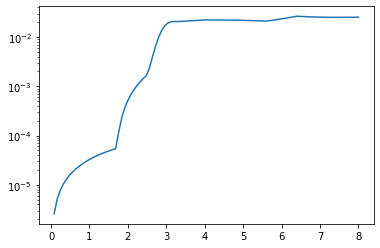

In [15]:
import tikzplotlib as tikz
plt.plot(t[1:],Glo_error)
plt.yscale('log')
tikz.save("graph_data/GE_t=0opt_only_surrogate.tex")

# Plot the results


In [11]:
#Plot functions
#Plot individual node over time
def plotnode(Solutions):
    index = 0
    for i in range(len(Solutions[:,0])):
        norm = torch.linalg.vector_norm(Solutions[i,:])
        if norm > torch.linalg.vector_norm(Solutions[index,:]):
            index = i
    plt.plot(t,Solutions[index,:])

#Plot pulse
def plotpulse(t):
    et = torch.zeros((len(t),))
    for i in range (len(t)):
        et[i] = e(t[i])
    plt.plot(t,et)

#Contour plot
def Contour(gammaR,gammaI,loss,shifts = None,randshifts = None,optshift = None):
    hold = torch.nan_to_num(loss,nan=1e0)
    levels = torch.logspace(torch.log10(torch.min(hold)),torch.log10(torch.max(hold)),11)
    cont = plt.contour(gammaR,gammaI,loss,levels,norm=LogNorm())
    fmt = '%1.1e'  # Exponential format
    plt.clabel(cont, inline=True, fontsize=8, fmt=fmt, colors='black', manual=False, inline_spacing=3)
    if optshift != None:
        marker = ['o','s']
        for i in range(len(optshift)):
            plt.plot(optshift[i].real,optshift[i].imag,marker = marker[i],color = 'k')
    if randshifts != None:
        plt.plot(randshifts.real,randshifts.imag,'^',color = [0,0.2,0.8])
    if shifts != None:
        col = [[1,0.1,0.2],[0,0.6,0.1]]
        for i in range(len(shifts)):
            plt.plot(shifts[i].real,shifts[i].imag,'x',color = col[i])
            for j in range (len(shifts[i])-1):
                plt.arrow(shifts[i][j].real,shifts[i][j].imag,shifts[i][j+1].real - shifts[i][j].real,shifts[i][j+1].imag - shifts[i][j].imag,linestyle = (3,(3,6)),color = col[i],head_length = 0)

def plotwavefunction(x,psi,index):
    for i in range (len(index)):
        plt.plot(x,torch.abs(torch.pow(psi[:,index[i]],2)))

def plotpotential(x,V,times):
    for i in range (len(times)):
        plt.plot(x,torch.abs(torch.diag(V(times[i]))))

def ploterror(t,error):
    plt.plot(t[1:],error)
    plt.yscale('log')

def plotshifts(t,shifts):
    plt.plot(t[1:],shifts.real)
    plt.plot(t[1:],shifts.imag)

def plotenergy(t,Total):
    # plt.plot(t,Potential)
    # plt.plot(t,Kinetic)
    plt.plot(t,Total)

def plotiterations(t,iterations):
    plt.plot(t[1:],iterations)

def plotoptimisation(error):
    plt.plot(torch.arange(len(error)),error)
    plt.yscale('log')

def plotgraph(adjacency_matrix,nodes, pos = None, clim = 1):#, mylabels
    rows, cols = np.where(adjacency_matrix != 0)
    weight = torch.abs(adjacency_matrix[rows,cols])
    w_edges = zip(rows.tolist(), cols.tolist(),weight.tolist())
    gr = nx.Graph()
    gr.add_weighted_edges_from(w_edges)
    # M = 500
    nodes = nodes[list(gr.nodes())]
    if pos == None:
        # pos = nx.spring_layout(gr,k=.5,iterations = 55)
        with open("graph_data/graph_pos.pkl","rb") as f:
            pos = pickle.load(f)    
    index = torch.sort(torch.abs(nodes.real))[1]
    # nodes = nodes[index]
    edge_colors = nodes[index].real#range(2, M + 2)
    # edge_colors = nodes.real
    # Define a custom color map
    colors = [(0, "lightskyblue"), (0.25, "midnightblue"), (0.5, "black"), (0.75, "maroon"), (1, "tomato")]  # Blue to black to red
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    # Set it as plt.cm.custom (you can choose any name instead of 'custom')
    plt.cm.custom = custom_cmap
    # cmap = plt.cm.afmhot
    cmap = plt.cm.custom
    
    # pos = {int(key): pos[int(key)] for key in index}
    # pos = {i: pos[int(key)] for i,key in enumerate(index)}
    nx.draw_networkx_edges(gr,pos=pos,width=weight/(torch.max(weight)), alpha=1)#,alpha = weight/(torch.max(weight))
    nx.draw_networkx_nodes(gr,pos = pos, node_size=10,node_color=edge_colors,cmap=cmap,vmin = -clim,vmax = clim,nodelist=index.tolist())#, labels=mylabels, with_labels=False
    plt.show()
    # return pos,gr.nodes(), edge_colors

(0.0, 100.0)

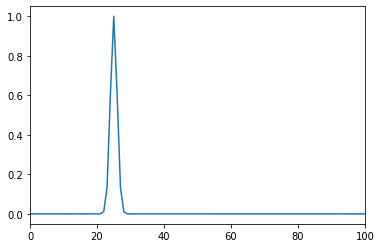

In [33]:
#Plot eigenfunction distribution for v
ind = torch.arange(1000)
ci = torch.zeros((1000,))
for i in range(1000):
    ci[i] = c(i)

plt.plot(ind,ci)
plt.xlim([0,100])

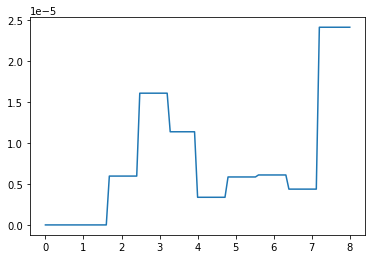

In [34]:
#Plot energy
plotenergy(t,torch.abs(energy)**2)

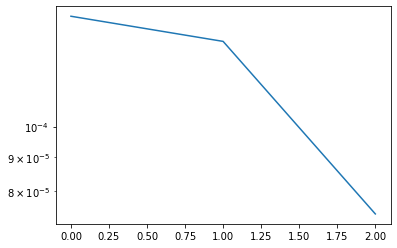

In [ ]:
#Plot optimiser objective at t=0
plotoptimisation(obj_loss)

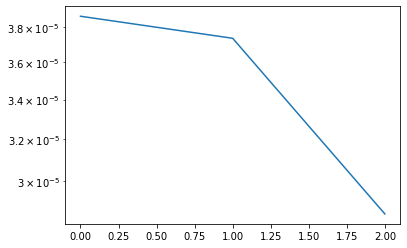

In [ ]:
#Plot optimiser true error at t=0
plotoptimisation(true_loss)

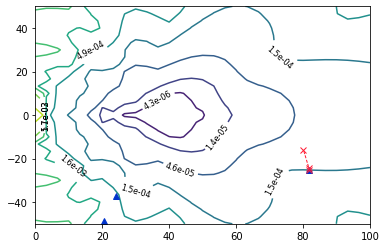

In [38]:
#Contour Plot of objective
loss = torch.load("graph_data/defect_sweep.pt")
true_shifts = torch.load("graph_data/optpath.pt")
randgammas = torch.load("graph_data/randshifts.pt")
Contour(gammaR,gammaI,loss,[true_shifts],randgammas)

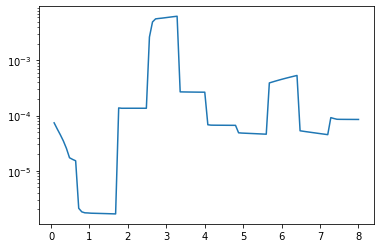

In [39]:
#Plot objective
ploterror(t,objective)

c:\Users\mt767\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:957: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


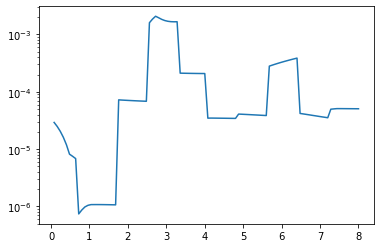

In [40]:
#Plot local error
ploterror(t,Loc_error)

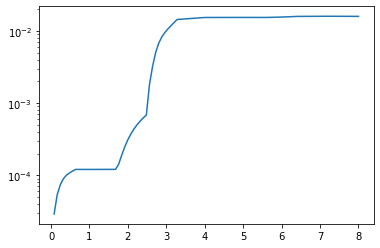

In [41]:
#Plot global error
ploterror(t,Glo_error)

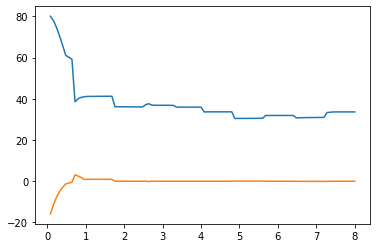

In [42]:
#Plot Shifts
plotshifts(t,opt_shifts_t)
# plt.ylim([-1,0])
# plt.ylim([17,19])

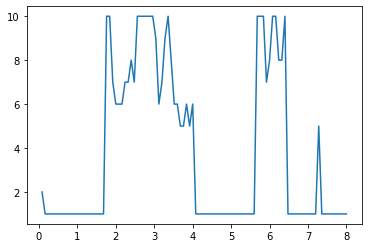

In [43]:
#Plot iterations
plotiterations(t,N_iter)

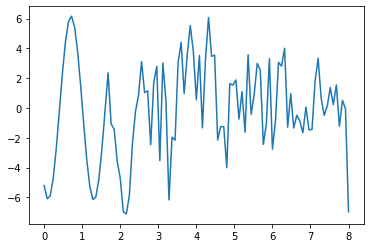

In [44]:
#Plot node over time
plotnode(Num_sols)

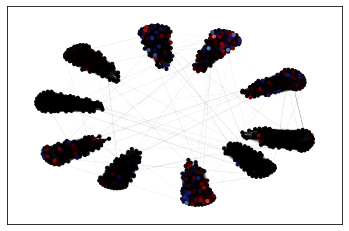

In [47]:
i = 0
# A1 = torch.load("variables/rand_blocks/A1.pt")
# A2 = torch.load("variables/rand_blocks/A2.pt")
M = magnus(A1,A2,t[i],dt)
# Num_sols = torch.load("results/Numerical_Solution.pt")
clim = np.max([torch.max(torch.abs(Num_sols[:,0])),torch.max(torch.abs(Num_sols[:,40])),torch.max(torch.abs(Num_sols[:,100]))])
x = Num_sols[:,i]
# x = torch.rand((len(M[:,0]),)) - .5

plotgraph(M,x,clim=clim/1)

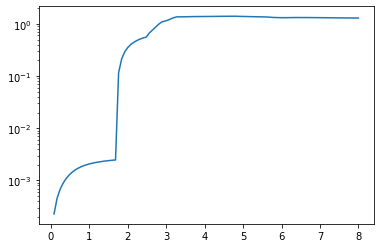

In [48]:
# Plot the polynomial Krylov error
ploterror(time,polyerr)